# Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nn_utils
import pandas as pd
%matplotlib inline

print('TensorFlow Version:', tf.__version__)

TensorFlow Version: 2.7.0


class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.L = len(layers)
        self.num_features = layers[0]
        self.num_classes = layers[-1]
        
        self.W = {}
        self.b = {}
        
        self.dW = {}
        self.db = {}
        
        self.setup()
        
    def setup(self):
        
        # Initalize weights
        for i in range(1, self.L):
            #Xavier Initialziation
            self.W[i] = tf.Variable(tf.random.normal(shape=(self.layers[i], self.layers[i-1])) * np.sqrt(2 / self.layers[0]))
            #self.W[i] = tf.Variable(tf.random.normal(shape=(self.layers[i], self.layers[i-1]))) #Wx+b
            self.b[i] = tf.Variable(tf.ones(shape=(self.layers[i],1))) #b
        
    def forward_pass(self, X):
        A = tf.convert_to_tensor(X, dtype=tf.float32) #Get input to work with tf
        for i in range(1, self.L):
            Z = tf.matmul(A,tf.transpose(self.W[i])) + tf.transpose(self.b[i])
            #activation
            if i!= self.L-1:
                A = tf.nn.relu(Z)
            else:
                #final layer activation, in this case nothing happens
                A=Z
        return A
    
    def compute_loss(self, A, Y):
        loss = tf.nn.softmax_cross_entropy_with_logits(Y,A)
        return tf.reduce_mean(loss)
    
    def update_params(self, lr):
        for i in range(1,self.L):
            self.W[i].assign_sub(lr*self.dW[i])
            self.b[i].assign_sub(lr*self.db[i])
            
    def predict(self, X):
        A = self.forward_pass(X)
        return tf.argmax(tf.nn.softmax(A), axis=1)
    
    def info(self):
        num_params = 0
        for i in range(1, self.L):
            num_params += self.W[i].shape[0] * self.W[i].shape[1]
            num_params += self.b[i].shape[0]
        print('Input Features:', self.num_features)
        print('Number of Classes:', self.num_classes)
        print('Hidden Layers:')
        print('--------------')
        for i in range(1, self.L-1):
            print('Layer {}, Units {}'.format(i, self.layers[i]))
        print('--------------')
        print('Number of parameters:', num_params)
        
    def train_on_batch(self, X, Y, lr):
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        Y = tf.convert_to_tensor(Y, dtype=tf.float32)
        
        with tf.GradientTape(persistent=True) as tape:
            A = self.forward_pass(X)
            loss = self.compute_loss(A, Y)
        
        for i in range(1, self.L):
            self.dW[i] = tape.gradient(loss, self.W[i])
            self.db[i] = tape.gradient(loss, self.b[i])
        del tape
        self.update_params(lr)
        return loss.numpy() 
    
    def train(self, x_train, y_train, x_test, y_test, epochs, steps_per_epoch, batch_size, lr):
        # Your code here
        history = {
            'val_loss': [], 
            'train_loss': [],
            'val_metric': []
        }
        
        for e in range(epochs):
            epoch_train_loss = 0
            print(f'Epoch {e}', end='.')
            for i in range(steps_per_epoch):
                x_batch = x_train[i*batch_size:(i+1)*batch_size]
                y_batch = y_train[i*batch_size:(i+1)*batch_size]
                
                batch_loss = self.train_on_batch(x_batch, y_batch, lr)
                epoch_train_loss += batch_loss
                
                if i%int(np.ceil(steps_per_epoch/10)) == 0:
                    print(end='.')
                    
            history['train_loss'] = epoch_train_loss
            val_A = self.forward_pass(x_test)
            val_loss = self.compute_loss(val_A, y_test).numpy()
            history['val_loss'] = val_loss
            val_preds = self.predict(x_test)
            val_metric = np.mean(val_preds.numpy() == np.argmax(y_test, axis=1))
            history['val_metric'] = val_metric
            print('val metric:', val_metric)
        return history

In [188]:
class NeuralNetworkNew:
    def __init__(self, layers, net_type='classification', dropout=None):
        self.layers = layers
        self.L = len(layers)
        self.net_type = net_type
        self.dropout = dropout
        self.num_features = layers[0]
        self.num_classes = layers[-1]
        
        self.W = {}
        self.b = {}
        
        self.dW = {}
        self.db = {}
        
        self.setup()
        
    def setup(self):
        
        # Initalize weights
        for i in range(1, self.L):
            #Xavier Initialziation, it does help with convergance
            self.W[i] = tf.Variable(tf.random.normal(shape=(self.layers[i], self.layers[i-1])) * np.sqrt(2 / self.layers[0]))
            #self.W[i] = tf.Variable(tf.random.normal(shape=(self.layers[i], self.layers[i-1]))) #Wx+b
            self.b[i] = tf.Variable(tf.ones(shape=(self.layers[i],1))) #b
        
    def forward_pass(self, X):
        A = tf.convert_to_tensor(X, dtype=tf.float32) #Get input to work with tf, important to keep type consistent
        for i in range(1, self.L):
            if self.dropout is not None:
                pass
            #Applying weights
            Z = tf.matmul(A,tf.transpose(self.W[i])) + tf.transpose(self.b[i])
            #activation
            if i!= self.L-1:
                A = tf.nn.relu(Z)
            else:
                #final layer activation, in this case nothing happens
                A=Z
        return A
    
    def compute_loss(self, A, Y):
        if self.net_type == 'classification':
            loss = tf.nn.softmax_cross_entropy_with_logits(Y,A)
        elif self.net_type == 'regression':
            mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
            loss = mse(Y,A)
        return tf.reduce_mean(loss)
        #return loss
    
    def update_params(self, lr):
        for i in range(1,self.L):
            self.W[i].assign_sub(lr*self.dW[i])
            self.b[i].assign_sub(lr*self.db[i])
            
    def predict(self, X):
        if self.net_type == 'classification':
            A = self.forward_pass(X)
            return tf.argmax(tf.nn.softmax(A), axis=1)
        elif self.net_type == 'regression':
            return self.forward_pass(X)
    
    def info(self):
        num_params = 0
        for i in range(1, self.L):
            num_params += self.W[i].shape[0] * self.W[i].shape[1]
            num_params += self.b[i].shape[0]
        print(f'Type: {self.net_type}')
        print('Input Features:', self.num_features)
        if self.net_type == 'classification':
            print('Number of Classes:', self.num_classes)
        print('Hidden Layers:')
        print('--------------')
        for i in range(1, self.L-1):
            print(f'Layer {i}, Units {self.layers[i]}')
        print('--------------')
        print('Number of parameters:', num_params)
        
    def train_on_batch(self, X, Y, lr):
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        Y = tf.convert_to_tensor(Y, dtype=tf.float32)
        
        with tf.GradientTape(persistent=True) as tape:
            A = self.forward_pass(X)
            loss = self.compute_loss(A, Y)
        
        for i in range(1, self.L):
            self.dW[i] = tape.gradient(loss, self.W[i])
            self.db[i] = tape.gradient(loss, self.b[i])
        del tape
        self.update_params(lr)
        return loss.numpy() 
    
    def metric(self, preds, y):
        if self.net_type == 'classification':
            return np.mean(preds.numpy() == np.argmax(y, axis=1))
        else:
            #print(preds)
            return np.square(preds.numpy() - y).mean()
    
    def train(self, x_train, y_train, x_test, y_test, epochs, steps_per_epoch, batch_size, lr):
        # Your code here
        history = {
            'val_loss': [], 
            'train_loss': [],
            'val_metrics': []
        }
        
        for e in range(epochs):
            epoch_train_loss = 0
            print(f'Epoch {e}', end='.')
            for i in range(steps_per_epoch):
                x_batch = x_train[i*batch_size:(i+1)*batch_size]
                y_batch = y_train[i*batch_size:(i+1)*batch_size]
                
                batch_loss = self.train_on_batch(x_batch, y_batch, lr)
                epoch_train_loss += batch_loss
                
                if i%int(np.ceil(steps_per_epoch/10)) == 0:
                    print(end='.')
                    
            history['train_loss'] = epoch_train_loss
            val_A = self.forward_pass(x_test)
            val_loss = self.compute_loss(val_A, y_test).numpy()
            history['val_loss'] = val_loss
            val_preds = self.predict(x_test)
            val_metric = self.metric(val_preds,y_test)
            history['val_metric'] = val_metric
            print('val metric:', val_metric)
        return history

# Experiments

In [180]:
!ls ../data/regression/

data.activation.test.10000.csv	 data.cube.test.10000.csv
data.activation.test.1000.csv	 data.cube.test.1000.csv
data.activation.test.100.csv	 data.cube.test.100.csv
data.activation.test.500.csv	 data.cube.test.500.csv
data.activation.train.10000.csv  data.cube.train.10000.csv
data.activation.train.1000.csv	 data.cube.train.1000.csv
data.activation.train.100.csv	 data.cube.train.100.csv
data.activation.train.500.csv	 data.cube.train.500.csv


In [143]:
dir_name = '../data/regression/data.'
name = 'cube.train.10000.csv'
train = pd.read_csv(dir_name+name)

name_test = 'cube.test.10000.csv'
test = pd.read_csv(dir_name+name_test)

train_X = np.array(train['x'])[...,None]
train_Y = np.array(train['y'])[...,None]


test_X = np.array(test['x'])[...,None]
test_Y = np.array(test['y'])[...,None]

test.head()

,x,y
0,-5.00,-1253.000000
1,-4.99,-1247.368296
2,-4.98,-1241.753168
3,-4.97,-1236.154592
4,-4.96,-1230.572544


In [145]:
train.head()

,x,y
0,2.752165,-5.273464
1,-0.255901,-18.276447
2,0.507626,3.871736
3,0.090452,-5.103992
4,-1.382406,-109.483782


In [181]:
net = NeuralNetworkNew([1,8,8,8,1], net_type='regression')
batch_size = 3000
epochs = 1000
steps_per_epoch = int(np.ceil(train_X.shape[0]/ batch_size))
lr = 0.0001

In [182]:
net.train(
    train_X, train_Y,
    test_X, test_Y,
    epochs, steps_per_epoch, 
    batch_size, lr
    
)

Epoch 0.....val metric: 138091.6150383525
Epoch 1.....val metric: 136084.7991991407
Epoch 2.....val metric: 133669.74332865677
Epoch 3.....val metric: 128371.1319557768
Epoch 4.....val metric: 114933.81556835496
Epoch 5.....val metric: 92692.44762510018
Epoch 6.....val metric: 74760.19187342536
Epoch 7.....val metric: 69012.39917201576
Epoch 8.....val metric: 66336.54327556674
Epoch 9.....val metric: 64694.03382073665
Epoch 10.....val metric: 63707.47842375883
Epoch 11.....val metric: 62413.072057666475
Epoch 12.....val metric: 61601.98809103135
Epoch 13.....val metric: 61009.87268081238
Epoch 14.....val metric: 60427.956180024266
Epoch 15.....val metric: 59869.85105439013
Epoch 16.....val metric: 59337.38818171293
Epoch 17.....val metric: 58813.831153690706
Epoch 18.....val metric: 58300.06328146002
Epoch 19.....val metric: 57796.5196222683
Epoch 20.....val metric: 57300.49692819376
Epoch 21.....val metric: 56812.56627417302
Epoch 22.....val metric: 56333.971522424195
Epoch 23.....val

Epoch 188.....val metric: 38667.65301704817
Epoch 189.....val metric: 38640.215526142114
Epoch 190.....val metric: 38612.65128938976
Epoch 191.....val metric: 38585.94093766699
Epoch 192.....val metric: 38560.450211754476
Epoch 193.....val metric: 38534.536696523144
Epoch 194.....val metric: 38508.32261278112
Epoch 195.....val metric: 38482.45752251529
Epoch 196.....val metric: 38456.84355077354
Epoch 197.....val metric: 38431.95138719036
Epoch 198.....val metric: 38406.21158230189
Epoch 199.....val metric: 38380.07466553183
Epoch 200.....val metric: 38354.31006366829
Epoch 201.....val metric: 38328.86477732044
Epoch 202.....val metric: 38301.95080869039
Epoch 203.....val metric: 38276.89892961027
Epoch 204.....val metric: 38253.04467276358
Epoch 205.....val metric: 38228.66368988835
Epoch 206.....val metric: 38203.77193814293
Epoch 207.....val metric: 38178.20498963892
Epoch 208.....val metric: 38152.13270424788
Epoch 209.....val metric: 38127.066740488284
Epoch 210.....val metric: 38

Epoch 374.....val metric: 35622.547117656344
Epoch 375.....val metric: 35618.43713256946
Epoch 376.....val metric: 35613.383978511636
Epoch 377.....val metric: 35608.17423381008
Epoch 378.....val metric: 35600.174405840655
Epoch 379.....val metric: 35594.93996744156
Epoch 380.....val metric: 35587.582131320225
Epoch 381.....val metric: 35582.466409438704
Epoch 382.....val metric: 35578.96467159274
Epoch 383.....val metric: 35573.26749273546
Epoch 384.....val metric: 35569.164277914526
Epoch 385.....val metric: 35562.24921546664
Epoch 386.....val metric: 35557.10816828323
Epoch 387.....val metric: 35551.905627452696
Epoch 388.....val metric: 35543.269943338695
Epoch 389.....val metric: 35537.73850441485
Epoch 390.....val metric: 35533.244079285985
Epoch 391.....val metric: 35528.16066035078
Epoch 392.....val metric: 35518.58134489854
Epoch 393.....val metric: 35512.586312733656
Epoch 394.....val metric: 35508.461827512605
Epoch 395.....val metric: 35503.24541324625
Epoch 396.....val met

Epoch 559.....val metric: 35418.83985564831
Epoch 560.....val metric: 35429.40075802492
Epoch 561.....val metric: 35449.080775213275
Epoch 562.....val metric: 35473.48330356587
Epoch 563.....val metric: 35498.00678452986
Epoch 564.....val metric: 35519.0285331469
Epoch 565.....val metric: 35531.01195789977
Epoch 566.....val metric: 35537.9151128608
Epoch 567.....val metric: 35540.066784061564
Epoch 568.....val metric: 35539.96254449936
Epoch 569.....val metric: 35534.77079554484
Epoch 570.....val metric: 35531.98687212559
Epoch 571.....val metric: 35531.54893020888
Epoch 572.....val metric: 35530.67087978901
Epoch 573.....val metric: 35527.422706551886
Epoch 574.....val metric: 35526.42277405712
Epoch 575.....val metric: 35525.51616991953
Epoch 576.....val metric: 35525.59873883593
Epoch 577.....val metric: 35526.23242162824
Epoch 578.....val metric: 35529.431954554784
Epoch 579.....val metric: 35534.49960085357
Epoch 580.....val metric: 35539.24650920489
Epoch 581.....val metric: 3554

Epoch 745.....val metric: 35639.72402642541
Epoch 746.....val metric: 35688.3088361014
Epoch 747.....val metric: 35752.00044102293
Epoch 748.....val metric: 35814.31944954651
Epoch 749.....val metric: 35869.04370232504
Epoch 750.....val metric: 35902.46396700148
Epoch 751.....val metric: 35913.28013411053
Epoch 752.....val metric: 35905.19634739641
Epoch 753.....val metric: 35887.325774064026
Epoch 754.....val metric: 35858.73466748723
Epoch 755.....val metric: 35825.23061291836
Epoch 756.....val metric: 35793.25347458895
Epoch 757.....val metric: 35758.99069903431
Epoch 758.....val metric: 35727.259929997024
Epoch 759.....val metric: 35698.808665161145
Epoch 760.....val metric: 35673.56997717747
Epoch 761.....val metric: 35647.13036461198
Epoch 762.....val metric: 35622.49677743482
Epoch 763.....val metric: 35602.62307859688
Epoch 764.....val metric: 35587.82821825277
Epoch 765.....val metric: 35577.30672569411
Epoch 766.....val metric: 35574.04252319613
Epoch 767.....val metric: 3557

Epoch 931.....val metric: 36155.960925790416
Epoch 932.....val metric: 36111.57891095807
Epoch 933.....val metric: 36072.12592215226
Epoch 934.....val metric: 36034.42283044908
Epoch 935.....val metric: 36003.934941010266
Epoch 936.....val metric: 35984.72391759966
Epoch 937.....val metric: 35973.41098719869
Epoch 938.....val metric: 35977.84728375843
Epoch 939.....val metric: 36000.83142783442
Epoch 940.....val metric: 36052.708717339105
Epoch 941.....val metric: 36114.31390922
Epoch 942.....val metric: 36165.106425026854
Epoch 943.....val metric: 36202.499843856174
Epoch 944.....val metric: 36218.76523592404
Epoch 945.....val metric: 36222.150620778804
Epoch 946.....val metric: 36205.94217766423
Epoch 947.....val metric: 36184.73139919219
Epoch 948.....val metric: 36167.79636189886
Epoch 949.....val metric: 36157.88289947242
Epoch 950.....val metric: 36158.305115612864
Epoch 951.....val metric: 36165.85328382805
Epoch 952.....val metric: 36176.311835406486
Epoch 953.....val metric: 3

{'val_loss': 36226.63,
 'train_loss': 43.5463981628418,
 'val_metrics': [],
 'val_metric': 36226.630731926016}

In [183]:
net.predict(test_X)

<tf.Tensor: shape=(1201, 1), dtype=float32, numpy=
array([[-505.49152 ],
       [-504.5059  ],
       [-503.5203  ],
       ...,
       [ 115.696846],
       [ 115.860825],
       [ 116.02482 ]], dtype=float32)>

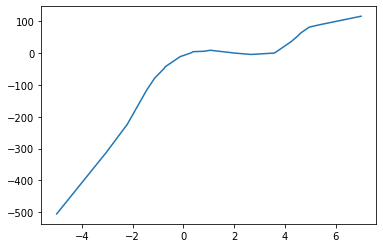

In [184]:
plt.plot(test_X, net.predict(test_X))

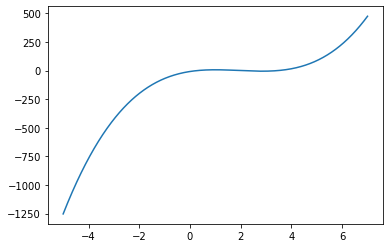

In [185]:
plt.plot(test_X, test_Y )

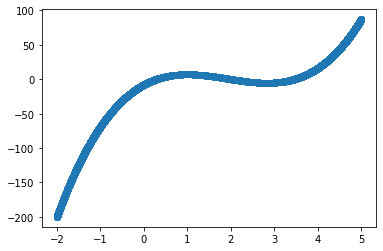

In [186]:
plt.scatter(train_X, train_Y)

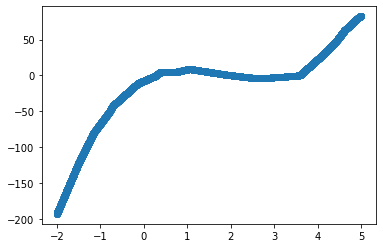

In [187]:
plt.scatter(train_X, net.predict(train_X))

## classification test

In [189]:
dir_name = '../data/classification/data.'
name = 'three_gauss.train.10000.csv'
train = pd.read_csv(dir_name+name)

name_test = 'three_gauss.test.10000.csv'
test = pd.read_csv(dir_name+name_test)
num_clases = len(train['cls'].unique())

train_X = np.array(train[['x','y']])
train_Y = np.zeros((len(train),num_clases))
train_Y[np.arange(len(train_X)),np.array(train['cls'])-1] = 1

randomize = np.arange(len(train_X))
np.random.shuffle(randomize)
train_X = train_X[randomize]
train_Y = train_Y[randomize]

test_X = np.array(test[['x','y']])
test_Y = np.zeros((len(test),num_clases))
test_Y[np.arange(len(test_X)),np.array(test['cls'])-1] = 1


randomize = np.arange(len(test_X))
np.random.shuffle(randomize)
test_X = test_X[randomize]
test_Y = test_Y[randomize]

In [190]:
train_X.shape

(30000, 2)

In [191]:
#test calssification, print prediction and reals
net = NeuralNetworkNew([2,16,16,3])

In [194]:
net.info()

Type: classification
Input Features: 2
Number of Classes: 3
Hidden Layers:
--------------
Layer 1, Units 16
Layer 2, Units 16
--------------
Number of parameters: 371


In [195]:
batch_size = 3000
epochs = 10
steps_per_epoch = int(np.ceil(train_X.shape[0]/ batch_size))
lr = 0.1

In [196]:
net.train(
    train_X, train_Y,
    test_X, test_Y,
    epochs, steps_per_epoch, 
    batch_size, lr
    
)

Epoch 0...........val metric: 0.9092666666666667
Epoch 1...........val metric: 0.9180333333333334
Epoch 2...........val metric: 0.9202333333333333
Epoch 3...........val metric: 0.9169333333333334
Epoch 4...........val metric: 0.9167
Epoch 5...........val metric: 0.9198333333333333
Epoch 6...........val metric: 0.9212
Epoch 7...........val metric: 0.9224333333333333
Epoch 8...........val metric: 0.9237
Epoch 9...........val metric: 0.9249


{'val_loss': 0.20020242,
 'train_loss': 1.9421938210725784,
 'val_metrics': [],
 'val_metric': 0.9249}

In [197]:
from matplotlib.lines import Line2D
def visualize_clas(X, Y, name=None):
    colors = {0: "tab:blue", 1: "tab:orange", 2: "tab:green"}
    colors_mapped = [colors[x] for x in list(Y)]
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.scatter(X[:, 0], X[:, 1], c=colors_mapped)

    # add a legend
    handles = [
        Line2D(
            [0], [0], marker="o", color="w", markerfacecolor=v, label=k, markersize=8
        )
        for k, v in colors.items()
    ]
    ax.legend(
        title="color", handles=handles, bbox_to_anchor=(1.05, 1), loc="upper left"
    )

    plt.show()
    if name:
        plt.savefig(name)